# Feature Engineering

This notebook will compute all the features.

The features will consist of:
- Rolling aggregates (mean, max, std) of anglez and enmo over a variety of window sizes, from 5 minutes to 8 hours.
- Rolling aggregates (mean, max, std) of anglez and enmo total variation (or first variation, i.e. 1v) over a variety of window sizes, from 5 minutes to 8 hours.


https://www.kaggle.com/code/lccburk/feature-engineering-and-random-forest-prediction

# GPT REVIEW


Data Types: Casting aggregates like mean and std to UInt16 may not be suitable if the rolling aggregates can have decimal places. Typically, aggregates are kept as float types.

Multiplying by 10: In the "Getting first variations" section, the results of rolling mean, max, and std of first differences are multiplied by 10. Ensure this operation is meaningful and necessary for your feature scaling or representation.

Abs before Cast: The code is taking the absolute value before casting, which makes sense for the max operation, but for mean and std, you would typically want to preserve the sign unless the domain specifically requires absolute values.

Circular Features: In the to_coord function, the expression (x % max_) is redundant since x should already be in the range [0, max_), assuming x is an hour, day, or month

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

from tqdm import tqdm

**Parameters**

In [2]:
WINDOW_SIZES = [5, 30, 2*60, 8*60] # 5min, 30min, 2hours, 8hours

ID_COLUMNS = ['series_id', 'step', 'timestamp']

TIME_COLUMNS = ['second', 'minute', 'hour', 'day', 'month']

FEATURE_TIME_NAMES = [
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "minute_sin",
    "minute_cos",
    "anglez_sin",
    "anglez_cos",
]


**Import Data**

In [3]:
df = pl.read_parquet('data/78569a801a38.parquet')

In [4]:
df = (
    df
    .with_row_count('step')
    .with_columns(
        year=df['timestamp'].dt.year().cast(pl.Int16),
        month=df['timestamp'].dt.month().cast(pl.Int8),
        day=df['timestamp'].dt.day().cast(pl.Int8),
        hour=df['timestamp'].dt.hour().cast(pl.Int8),
        minute=df['timestamp'].dt.minute().cast(pl.Int8),
        second=df['timestamp'].dt.second().cast(pl.Int8),
    )
)

**Rolling Features**

In [5]:
features, feature_cols = [], []

for mins in WINDOW_SIZES :
    for var in ['enmo', 'anglez'] :
        
        # Getting basic features
        features += [
            pl.col(var).rolling_mean(2 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_mean'),
            pl.col(var).rolling_max(2 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_max'),
            pl.col(var).rolling_std(2 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_std')
        ]

        feature_cols += [ 
            f'{var}_{mins}m_mean', f'{var}_{mins}m_max', f'{var}_{mins}m_std'
        ]

        # Getting first variations
        features += [
            (pl.col(var).diff().abs().rolling_mean(2 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(2 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max'),
            (pl.col(var).diff().abs().rolling_std(2 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_std')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max', f'{var}_1v_{mins}m_std'
        ]



In [6]:
train_series = df.with_columns(
    features
)


**Circular Features**

In [7]:
def to_coord(x: pl.Expr, max_: int, name: str) -> list[pl.Expr]:
    rad = 2 * np.pi * (x % max_) / max_
    x_sin = rad.sin()
    x_cos = rad.cos()

    return [x_sin.alias(f"{name}_sin"), x_cos.alias(f"{name}_cos")]


def add_feature(series_df: pl.DataFrame) -> pl.DataFrame:
    series_df = (
        series_df
        .with_columns(
            *to_coord(pl.col("hour"), 24, "hour"),
            *to_coord(pl.col("month"), 12, "month"),
            *to_coord(pl.col("minute"), 60, "minute"),
            pl.col('anglez').sin().alias('anglez_sin'),
            pl.col('anglez').cos().alias('anglez_cos'),
        )
    )
    return series_df

In [8]:
df = add_feature(train_series)

In [9]:
df2 = df.to_pandas()

In [10]:
df2.columns

Index(['step', 'series_id', 'timestamp', 'anglez', 'enmo', 'literal', 'state',
       'wakeup', 'onset', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'enmo_5m_mean', 'enmo_5m_max', 'enmo_5m_std', 'enmo_1v_5m_mean',
       'enmo_1v_5m_max', 'enmo_1v_5m_std', 'anglez_5m_mean', 'anglez_5m_max',
       'anglez_5m_std', 'anglez_1v_5m_mean', 'anglez_1v_5m_max',
       'anglez_1v_5m_std', 'enmo_30m_mean', 'enmo_30m_max', 'enmo_30m_std',
       'enmo_1v_30m_mean', 'enmo_1v_30m_max', 'enmo_1v_30m_std',
       'anglez_30m_mean', 'anglez_30m_max', 'anglez_30m_std',
       'anglez_1v_30m_mean', 'anglez_1v_30m_max', 'anglez_1v_30m_std',
       'enmo_120m_mean', 'enmo_120m_max', 'enmo_120m_std', 'enmo_1v_120m_mean',
       'enmo_1v_120m_max', 'enmo_1v_120m_std', 'anglez_120m_mean',
       'anglez_120m_max', 'anglez_120m_std', 'anglez_1v_120m_mean',
       'anglez_1v_120m_max', 'anglez_1v_120m_std', 'enmo_480m_mean',
       'enmo_480m_max', 'enmo_480m_std', 'enmo_1v_480m_mean',
       '

In [11]:
y = df['state']
X = df[list(set(df.columns) - set(ID_COLUMNS))]

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [14]:
y_pred = clf.predict(X_test)

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

accuracy_score(y_test, y_pred)

1.0

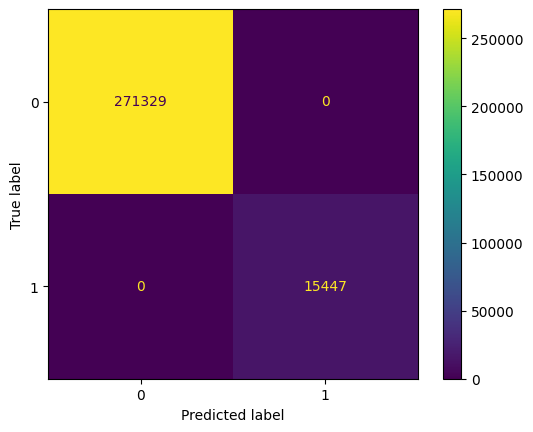

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()